# Generate Images With Variational Autoencoders

Sampling from a latent space of images to create entirely new images or edit existing ones is currently the most popular and successful application of creative AI. In this section and the next, we’ll review some high-level concepts pertaining to image generation, alongside implementations details relative to the two main techniques in this domain: ***variational autoencoders (VAEs)*** and ***generative adversarial networks (GANs)***. The techniques we present here aren’t specific to images— we could develop latent spaces of sound, music, or even text, using GANs and VAEs—but in practice, the most interesting results have been obtained with pictures, and that’s what we focus on here.

### Sampling From Latent Spaces of Images

The key idea of image generation is to develop a low-dimensional *latent space* of representations (which naturally is a vector space) where any point can be mapped to a realistic-looking image. The module capable of realizing this mapping, taking as input
a latent point and outputting an image (a grid of pixels), is called a *generator* (in the case of GANs) or a *decoder* (in the case of VAEs). Once such a latent space has been developed, we can sample points from it, either deliberately or at random, and, by mapping them to image space, generate images that have never been seen before.

![capture](https://user-images.githubusercontent.com/13174586/52051868-d6b5fe80-257a-11e9-980a-5c197676415c.JPG)

GANs and VAEs are two different strategies for learning such latent spaces of image representations, each with its own characteristics. VAEs are great for learning latent spaces that are well structured, where specific directions encode a meaningful axis of variation in the data. GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuity.

![capture](https://user-images.githubusercontent.com/13174586/52053069-51cce400-257e-11e9-9db3-467db044a818.JPG)

### Concept Vectors for Image Editing
We already hinted at the idea of a concept vector. The idea is still the same: given a latent space of representations, or an
embedding space, certain directions in the space may encode interesting axes of variation in the original data. In a latent space of images of faces, for instance, there may be a smile vector s, such that if latent point z is the embedded representation of a certain face, then latent point z + s is the embedded representation of the same face, smiling. Once we’ve identified such a vector, it then becomes possible to edit images by projecting them into the latent space, moving their representation in a meaningful way, and then decoding them back to image space. There are concept vectors for essentially any independent dimension of variation in image space—in the case of faces, we may discover vectors for adding sunglasses to a face, removing glasses, turning a male face into as female face, and so on. Below is an example of a smile vector, a concept vector discovered by Tom White from the Victoria University School of Design in New Zealand, using VAEs trained on a dataset of faces of celebrities (the CelebA dataset).

![capture](https://user-images.githubusercontent.com/13174586/52053484-75dcf500-257f-11e9-9a25-573dc66c4603.JPG)

Variational autoencoders, are a kind of generative model that’s especially appropriate for the task of image editing via concept vectors. They’re a modern take on autoencoders—a type of network that aims to encode an input to a low-dimensional latent space and then decode it back—that mixes ideas from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module. It’s then trained by using as target data the same images as the input images, meaning the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the code (the output of the encoder), we can get the autoencoder to learn more-or-less interesting latent representations of the data. Most commonly, we’ll constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

![capture](https://user-images.githubusercontent.com/13174586/52053819-745ffc80-2580-11e9-9b80-9e456ddcee55.JPG)

In practice, such classical autoencoders don’t lead to particularly useful or nicely structured latent spaces. They’re not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAEs, however, augment autoencoders
with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means we’re assuming the input image has been generated by a
statistical process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element
back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

![capture](https://user-images.githubusercontent.com/13174586/52055551-b9d2f880-2585-11e9-8cf9-3f430dd60a62.JPG)

In technical terms, here’s how a VAE works:
 - An encoder module turns the input samples input_img into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
 - We randomly sample a point `z` from the latent normal distribution that’s assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where epsilon is a random tensor of small values.
 - A decoder module maps this point in the latent space back to the original input image.
 
Because epsilon is random, the process ensures that every point that’s close to the latent location where we encoded `input_img` (z-mean) can be decoded to something similar to input_img, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well-formed latent spaces and reduce overfitting to the training data. Let’s quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

In [ ]:
z_means, z_log_variance= encoder(input_img) #Encodes the input into a mean and variance parameter

z= z_mean+ exp(z_log_variance)*encoder #Draws a latent point using a small random epsilon

reconstructed_image= decoder(z) #Decodes z back to an image

model= Model(input_img, reconstructed_img) #Instantiates the autoencoder model, which maps an input image to its reconstruction

We can then train the model using the reconstruction loss and the regularization loss. The following listing shows the encoder network we’ll use, mapping images to the parameters of a probability distribution over the latent space. It’s a simple convnet
that maps the input image x to two vectors, `z_mean` and `z_log_var`.

### VAE Encoder Network

In [12]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape= (28,28,1)
batch_size= 16
latent_dim= 2

input_img= keras.Input(shape= img_shape)

x= layers.Conv2D(32,3, padding='same', activation='relu')(input_img)
x= layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x= layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x= layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening= K.int_shape(x)

x= layers.Flatten()(x)
x= layers.Dense(32, activation='relu')(x)

z_mean= layers.Dense(latent_dim)(x)          #The input image ends up being encoded
z_log_var= layers.Dense(latent_dim)(x)  #into these two parameters

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point z. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a Lambda layer. In Keras, everything needs to be a layer, so code that isn’t part of a builtin layer should be wrapped in a Lambda (or in a custom layer).

### Latent-Space-Sampling Function

In [16]:
def sampling(args):
    z_mean, z_log_var= args
    
    epsilon= K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean+ K.exp(z_log_var)*epsilon

z= layers.Lambda(sampling)([z_mean, z_log_var])

The following listing shows the decoder implementation. We reshape the vector `z` to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

### VAE Decoder Network, Mapping Latent Space Points to Images

In [24]:
decoder_input= layers.Input(K.int_shape(z)[1:]) #Input where we’ll feed z

x= layers.Dense(np.prod(shape_before_flattening[1:]),             #Upsamples the input
               activation='relu')(decoder_input)

x= layers.Reshape(shape_before_flattening[1:])(x) #Reshapes z into a feature map of the same shape as the feature
                                                   #map just before the last Flatten layer in the encoder model

x= layers.Conv2DTranspose(32, 3,                        
                         padding='same',
                         activation='relu', 
                         strides=(2,2))(x)                           #Uses a Conv2DTranspose layer and Conv2D layer to   
                                                                     #decode z into a feature map the same
x= layers.Conv2D(1,3, padding='same',activation='sigmoid')(x)        #size as the original image input

In [25]:
decoder= Model(decoder_input, x) #Instantiates the decoder model which turns “decoder_input” into the decoded image

z_decoded= decoder(z)  #Applies it to z to recover the decoded z

The dual loss of a VAE doesn’t fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we’ll set up the loss by writing a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss.

### Custom Layer Used to Compute The VAE Loss

In [30]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x= K.flatten(x)
        z_decoded= K.flatten(z_decoded)
        xcent_loss= keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss= -5e-4*K.mean(1+z_log_var-K.square(z_mean)- K.exp(z_log_var), axis=1)
        return K.mean(xcent_loss+kl_loss)
    
    def call(self, inputs):              #We implement custom layers by writing a call method
        x= inputs[0]
        z_decoded= inputs[1]
        loss= self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x                         #We don't use this output, but the layer must return something.
        
y= CustomVariationalLayer()([input_img, z_decoded]) #Calls the custom layer on the input and the 
                                                   #decoded output to obtain the final model output

Finally, we’re ready to instantiate and train the model. Because the loss is taken care of in the custom layer, we don’t specify an external loss at compile time (`loss=None`), which in turn means we won’t pass target data during training (as we can see, we
only pass `x_train` to the model in `fit`).

### Training The VAE

In [31]:
from keras.datasets import mnist

vae= Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [33]:
(x_train,_), (x_test, _)= mnist.load_data()

x_train= x_train.astype('float32')/255
x_train= x_train.reshape(x_train.shape+(1,))

x_test= x_test.astype('float32')/255
x_test= x_test.reshape(x_test.shape+(1,))

In [34]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data= (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 514us/step - loss: 144443432.6305 - val_loss: 0.1978
Epoch 2/10
60000/60000 [==============================] - 31s 509us/step - loss: 0.1946 - val_loss: 0.1908
Epoch 3/10
60000/60000 [==============================] - 31s 519us/step - loss: 0.1896 - val_loss: 0.1879
Epoch 4/10
60000/60000 [==============================] - 31s 510us/step - loss: 0.1870 - val_loss: 0.1869
Epoch 5/10
60000/60000 [==============================] - 29s 490us/step - loss: 0.1852 - val_loss: 0.1841
Epoch 6/10
60000/60000 [==============================] - 29s 490us/step - loss: 0.1839 - val_loss: 0.1844
Epoch 7/10
60000/60000 [==============================] - 31s 509us/step - loss: 0.1831 - val_loss: 0.1847
Epoch 8/10
60000/60000 [==============================] - 32s 540us/step - loss: 0.1822 - val_loss: 0.1828
Epoch 9/10
60000/60000 [==============================] - 32s 530us/step - loss: 0.181

Once such a model is trained—on MNIST, in this case— we can use the decoder network to turn arbitrary latent space vectors into images.

### Sampling A Grid of Points From The 2D Latent Space and Decoding Them to Images

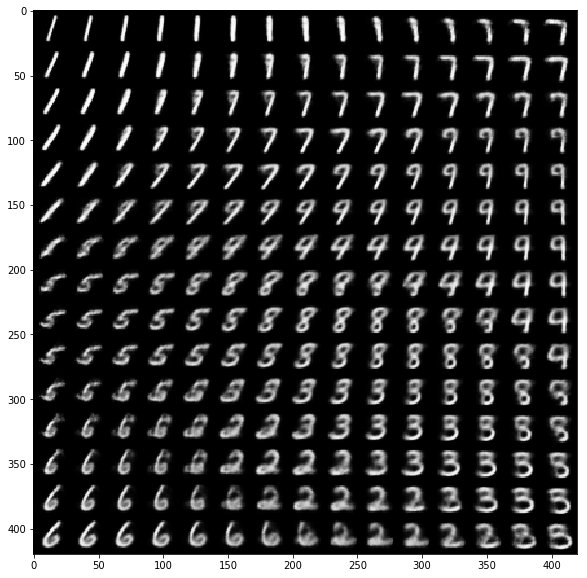

In [40]:
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

n= 15         #We'll display a grid of 15 × 15 digits (255 digits total)
digit_size=28                                 #Transforms linearly spaced
figure=np.zeros((digit_size*n, digit_size*n)) #coordinates using the SciPy ppf
grid_x= norm.ppf(np.linspace(0.05, 0.95, n))  #function to produce values of the
grid_y= norm.ppf(np.linspace(0.05, 0.95, n))  #latent variable z (because the prior
                                              #of the latent space is Gaussian)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample= np.array([[xi, yi]])
        z_sample= np.tile(z_sample, batch_size).reshape(batch_size, 2) #Repeats z multiple times to form a complete batch
        x_decoded= decoder.predict(z_sample, batch_size=batch_size)    #Decodes the batch into digit images
        digit= x_decoded[0].reshape(digit_size, digit_size)  #Reshapes the first digit in the batch from 28 × 28 × 1 to 28 × 28
        figure[i*digit_size:(i+1)*digit_size,
              j*digit_size:(j+1)*digit_size]= digit
        
plt.figure(figsize= (10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits above shows a completely continuous distribution of the different digit classes, with one digit morphing into another as we follow a path through latent space. Specific directions in this space have a meaning: for example, there’s a direction for “four-ness,” “one-ness,” and so on.